# Setup

## Imports

In [572]:
using Pkg
Pkg.activate("SCC", shared=true)

import QuantumToolbox as qt
import SuperconductingCavities as SC
import CairoMakie as cm
using Revise
using Dates
import JSON3

using LinearAlgebra
using YAXArrays

using ProgressMeter

import Optim as opt

using Logging
using MiniLoggers

using TensorOperations

import LsqFit as LF

using IJulia
if isdefined(Main, :IJulia)
   Main.IJulia.stdio_bytes[] = 0;
end
import IJulia

cm.activate!(type = "png")

  Activating project at `~/.julia/environments/SCC`


## Logger Setups

In [2]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(18) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

In [3]:
Mode3 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode3/Mode3.json");

In [4]:
length(Mode3.dressed_states[(0,0)])

100

# Looking at Quasienergies

In [5]:
Δf(ε) = sum([Mode3.Stuff["Chirp Params"]["fn_gn+1"][1]["param"][n]*ε^n for n in 1:length(Mode3.Stuff["Chirp Params"]["fn_gn+1"][1]["param"])])

Δf (generic function with 1 method)

In [590]:
dat = open_dataset("Data/FloqIonization_Tue-Jan-14-25_22_10/quasienergies.nc")
#dat = open_dataset("Data/Quasienergies_Tue-Jan-7-25_00_05.nc")

YAXArray Dataset
Shared Axes: 
  (↓ state Categorical{String} [(7, 1), (0, 3), …, (9, 0), (6, 7)] Unordered,
  → eps   Sampled{Float64} 0.5:0.007537688442211055:2.0 ForwardOrdered Regular Points,
  ↗ shift Sampled{Float64} 0.01:0.001457286432160804:0.3 ForwardOrdered Regular Points)

Variables: 
layer



In [591]:
dat.cubes[:layer].axes

(↓ state Categorical{String} [(7, 1), (0, 3), …, (9, 0), (6, 7)] Unordered,
→ eps   Sampled{Float64} 0.5:0.007537688442211055:2.0 ForwardOrdered Regular Points,
↗ shift Sampled{Float64} 0.01:0.001457286432160804:0.3 ForwardOrdered Regular Points)

In [592]:
#println(fieldnames(typeof(dat.cubes[:layer][eps = At(0.5), state = At(string((7,1))), shift = At(0.03)])))
#at.cubes[:layer][eps = At(0.5), state = At(string((7,1))), shift = At(0.03)][1]

In [593]:
stark_shifts = (dat.axes[:shift]);
states = (dat.axes[:state]);
eps = (dat.axes[:eps]);

In [594]:
state1 = (2,0)
state2 = (0,1)

y1 = collect(dat.cubes[:layer][state= At(string(state1))].data)/(pi)
y2 = collect(dat.cubes[:layer][state= At(string(state2))].data)/(pi)

for i in 1:length(stark_shifts)
    ν = abs(Mode3.Stuff["op_drive_params"]["sb_f0g1"]["freq_d"] + stark_shifts[i])
    y1[i,:] = [y1[i, j] >= 0 ? y1[i,j] : 2*ν + y1[i,j] for j in 1:length(y1[i,:])]
    y2[i,:] = [y2[i, j] >= 0 ? y2[i,j] : 2*ν + y2[i,j] for j in 1:length(y2[i,:])]
end
abs_difs1 = abs.(y1-y2)
abs_difs2 = zeros(size(abs_difs1))

for i in 1:length(stark_shifts)
    ν = abs(Mode3.Stuff["op_drive_params"]["sb_f0g1"]["freq_d"] + stark_shifts[i])
    abs_difs2[:,i] += abs.(-abs_difs1[:,i].+2*ν)
end

abs_difs = min.(abs_difs1, abs_difs2);

In [595]:
Δf.(collect(eps.val));

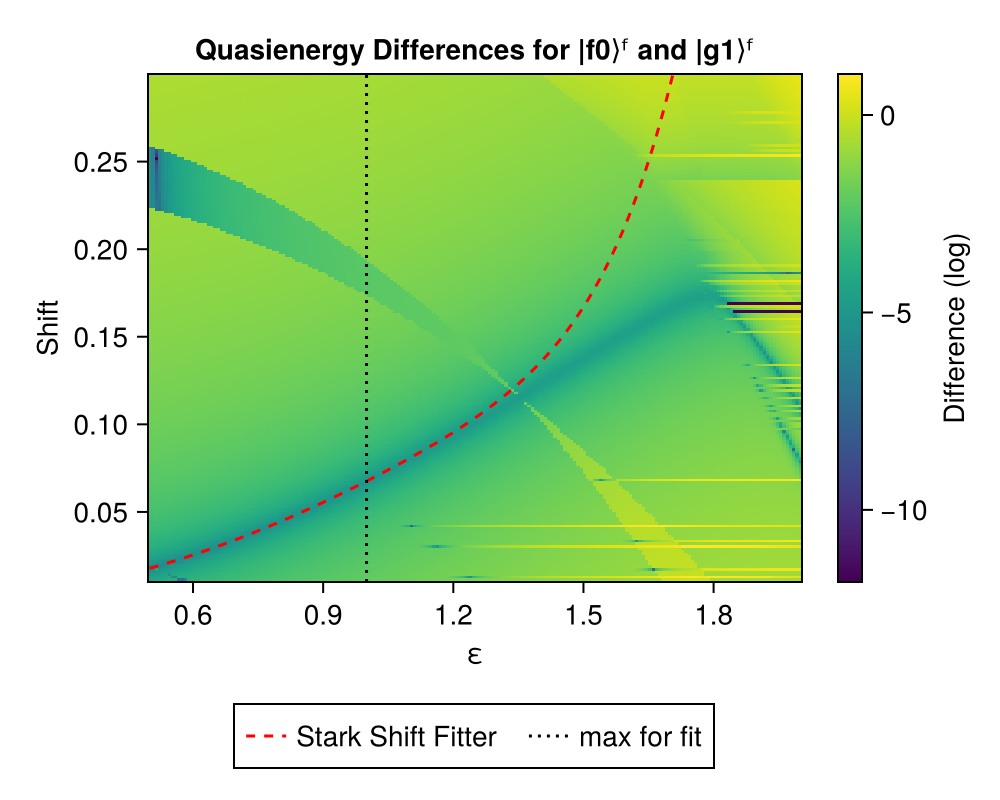

CairoMakie.Screen{IMAGE}


In [596]:
fig = cm.Figure(size = (500,400))
ax = cm.Axis(fig[1,1], xlabel = "ε", ylabel = "Shift", title = "Quasienergy Differences for |f0⟩ᶠ and |g1⟩ᶠ", limits = (nothing, (minimum(stark_shifts), maximum(stark_shifts))))

to_plot = log.(abs_difs)
cm.heatmap!(ax, collect(eps.val), collect(stark_shifts), to_plot)
cm.lines!(collect(eps.val), Δf.(collect(eps.val)), color = "red", label = "Stark Shift Fitter", linestyle = :dash)
cm.vlines!(1, color = "black", linestyle = :dot, label = "max for fit")

cm.Colorbar(fig[1,2], limits = [minimum(to_plot[to_plot .> -Inf]), maximum(to_plot)], label = "Difference (log)")
cm.Legend(fig[2,1], ax, orientation = :horizontal)



display(fig)

In [436]:
minimum(to_plot[to_plot .> -Inf])

0.0002342940560497997

# Looking at Floquet Modes

In [597]:
fmodes = open_dataset("Data/FloqIonization_Tue-Jan-14-25_22_10/quasistates.nc")

YAXArray Dataset
Shared Axes: 
  (↓ state Categorical{String} [(7, 1), (0, 3), …, (9, 0), (6, 7)] Unordered,
  → eps   Sampled{Float64} 0.5:0.007537688442211055:2.0 ForwardOrdered Regular Points,
  ↗ shift Sampled{Float64} 0.01:0.001457286432160804:0.3 ForwardOrdered Regular Points,
  ⬔ Re_Im Categorical{String} ["Re", "Im"] ReverseOrdered,
  ◩ idx   Sampled{Int64} 1:1:100 ForwardOrdered Regular Points)

Variables: 
layer



## Transmon Levels

In [599]:
stark_shifts = (fmodes.axes[:shift]);
states = (fmodes.axes[:state]);
eps = (fmodes.axes[:eps]);

In [600]:
state = (2,0)
fmode_dat_f0 = collect(fmodes.layer[Re_Im = At("Re"), state = At(string(state))].data+1im*fmodes.layer[Re_Im = At("Im"), state = At(string(state))].data);
fmode_dat_f0_cc = collect(fmodes.layer[Re_Im = At("Re"), state = At(string(state))].data-1im*fmodes.layer[Re_Im = At("Im"), state = At(string(state))].data);

state = (0,1)
fmode_dat_g1 = collect(fmodes.layer[Re_Im = At("Re"), state = At(string(state))].data+1im*fmodes.layer[Re_Im = At("Im"), state = At(string(state))].data);
fmode_dat_g1_cc = collect(fmodes.layer[Re_Im = At("Re"), state = At(string(state))].data-1im*fmodes.layer[Re_Im = At("Im"), state = At(string(state))].data);

In [601]:
tmat = zeros(10,10)
id_mat = zeros(10,10)
for i in 1:10
    tmat[i,i] = i-1
    id_mat[i,i] = 1
end

tmat = kron(tmat, id_mat)

dat_for_plot_f0 = abs.(sum([fmode_dat_f0_cc[:,:,m].*tmat[m,n].*fmode_dat_f0[:,:,n] for n in 1:100 for m in 1:100]));
dat_for_plot_g1 = abs.(sum([fmode_dat_g1_cc[:,:,m].*tmat[m,n].*fmode_dat_g1[:,:,n] for n in 1:100 for m in 1:100]));

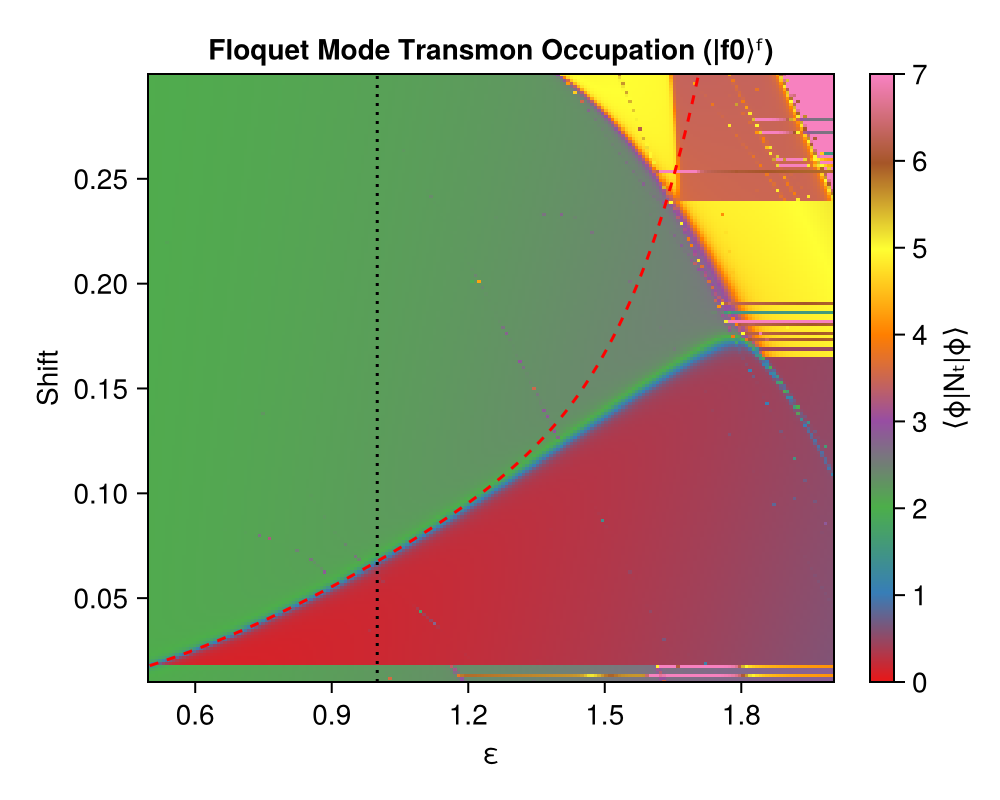

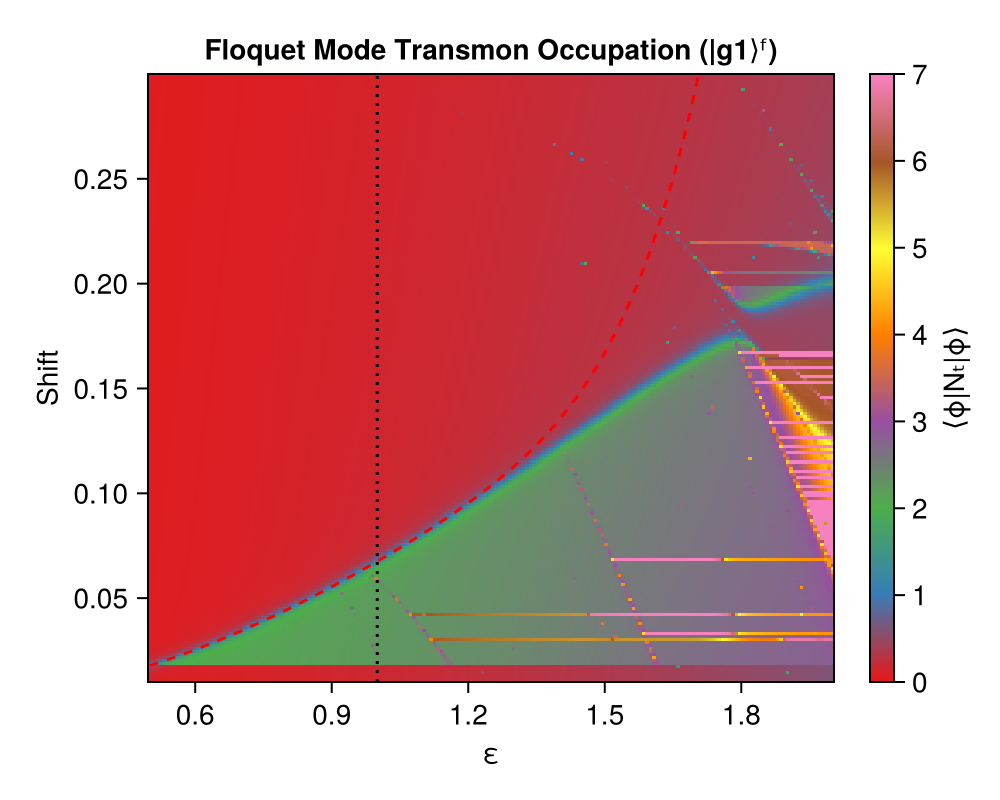

CairoMakie.Screen{IMAGE}


In [602]:
fig = cm.Figure(size = (500,400))
ax = cm.Axis(fig[1,1], xlabel = "ε", ylabel = "Shift", title = "Floquet Mode Transmon Occupation (|f0⟩ᶠ)", limits = (nothing, (minimum(stark_shifts), maximum(stark_shifts))))

joint_limits = [0,7]
cmap = :Set1_8
to_plot = dat_for_plot_f0
hm = cm.heatmap!(ax, collect(eps.val), collect(stark_shifts), to_plot, colormap = cmap, colorrange = joint_limits)
cm.lines!(collect(eps.val), Δf.(collect(eps.val)), color = "red", label = "Stark Shift Fitter", linestyle = :dash)
cm.vlines!(1, color = "black", linestyle = :dot, label = "max for fit")

cm.Colorbar(fig[1,2], hm, label = "⟨ϕ|Nₜ|ϕ⟩", ticks = joint_limits[1]:joint_limits[end])
#cm.Legend(fig[2,1], ax, orientation = :horizontal)

display(fig)

fig = cm.Figure(size = (500,400))
ax = cm.Axis(fig[1,1], xlabel = "ε", ylabel = "Shift", title = "Floquet Mode Transmon Occupation (|g1⟩ᶠ)", limits = (nothing, (minimum(stark_shifts), maximum(stark_shifts))))

to_plot = dat_for_plot_g1
hm = cm.heatmap!(ax, collect(eps.val), collect(stark_shifts), to_plot, colormap = cmap, colorrange = joint_limits)
cm.lines!(collect(eps.val), Δf.(collect(eps.val)), color = "red", label = "Stark Shift Fitter", linestyle = :dash)
cm.vlines!(1, color = "black", linestyle = :dot, label = "max for fit")

cm.Colorbar(fig[1,2], hm, label = "⟨ϕ|Nₜ|ϕ⟩", ticks = joint_limits[1]:joint_limits[end])
#cm.Legend(fig[2,1], ax, orientation = :horizontal)

display(fig)

In [648]:
collect(stark_shifts.val)[20]

0.03768844221105527

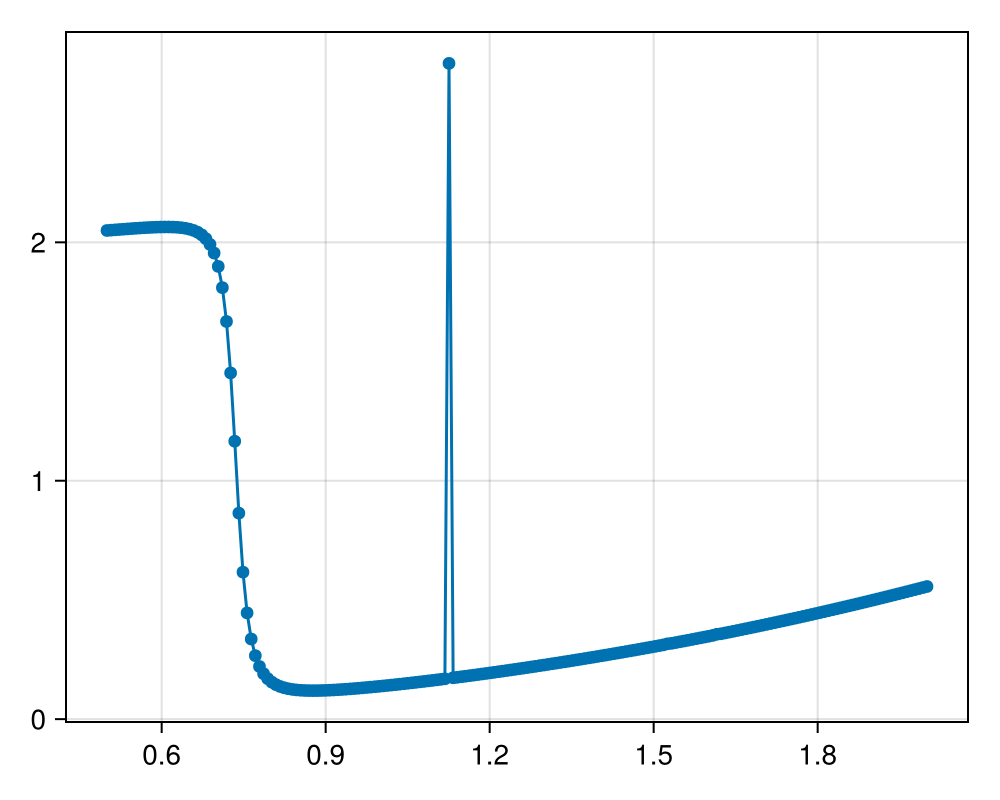

CairoMakie.Screen{IMAGE}


In [649]:
fig = cm.Figure(size = (500,400))
ax = cm.Axis(fig[1,1])

to_plot = dat_for_plot_f0
cm.scatterlines!(collect(eps.val), to_plot[:,20])

display(fig)

## Floquet Mode Overlap

In [443]:
stark_shifts = (fmodes.axes[:shift]);
states = (fmodes.axes[:state]);
eps = (fmodes.axes[:eps]);

In [444]:
state = (2,0)
fmode_dat_f0 = collect(fmodes.layer[Re_Im = At("Re"), state = At(string(state))].data+1im*fmodes.layer[Re_Im = At("Im"), state = At(string(state))].data);

state = (0,1)
fmode_dat_g1_cc = collect(fmodes.layer[Re_Im = At("Re"), state = At(string(state))].data-1im*fmodes.layer[Re_Im = At("Im"), state = At(string(state))].data);

In [445]:
nmat = Mode3.n̂ₜ.data;

dat_for_plot_overlap = abs.(sum([fmode_dat_g1_cc[:,:,n].*fmode_dat_f0[:,:,n] for n in 1:100]));

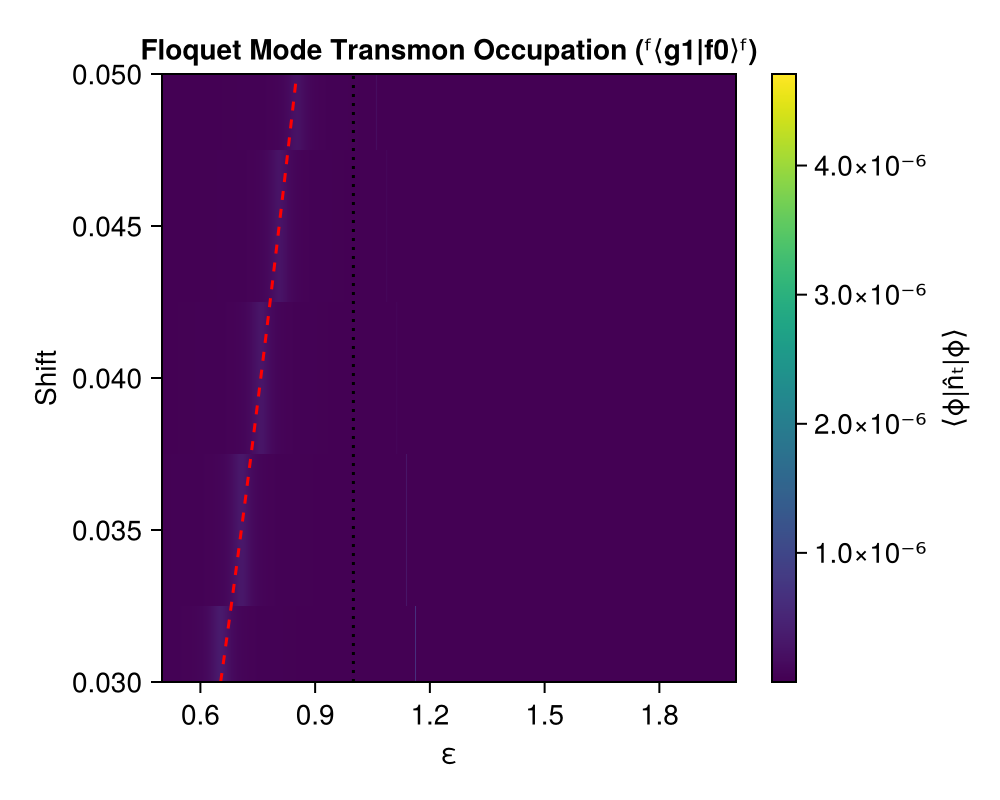

CairoMakie.Screen{IMAGE}


In [446]:
fig = cm.Figure(size = (500,400))
ax = cm.Axis(fig[1,1], xlabel = "ε", ylabel = "Shift", title = "Floquet Mode Transmon Occupation (ᶠ⟨g1|f0⟩ᶠ)", limits = (nothing, (minimum(stark_shifts), maximum(stark_shifts))))

to_plot = dat_for_plot_overlap
cm.heatmap!(ax, collect(eps.val), collect(stark_shifts), to_plot)
cm.lines!(collect(eps.val), Δf.(collect(eps.val)), color = "red", label = "Stark Shift Fitter", linestyle = :dash)
cm.vlines!(1, color = "black", linestyle = :dot, label = "max for fit")

cm.Colorbar(fig[1,2], limits = [minimum(to_plot[to_plot .> -Inf]), maximum(to_plot)], label = "⟨ϕ|n̂ₜ|ϕ⟩")
#cm.Legend(fig[2,1], ax, orientation = :horizontal)


display(fig)

## Checking Floquet Mode Tracking

In [448]:
stark_shifts = (fmodes.axes[:shift]);
states = (fmodes.axes[:state]);
eps = (fmodes.axes[:eps]);

In [449]:
state = (0,1)
fmode_dat = collect(fmodes.layer[Re_Im = At("Re"), state = At(string(state))].data+1im*fmodes.layer[Re_Im = At("Im"), state = At(string(state))].data);

fmode_dat_cc = collect(fmodes.layer[Re_Im = At("Re"), state = At(string(state))].data-1im*fmodes.layer[Re_Im = At("Im"), state = At(string(state))].data);

In [451]:
nmat = Mode3.n̂ₜ.data;

dat_for_plot_overlap = abs.(sum([fmode_dat_cc[1:(end-1),:,n].*fmode_dat[2:end,:,n] for n in 1:100]));

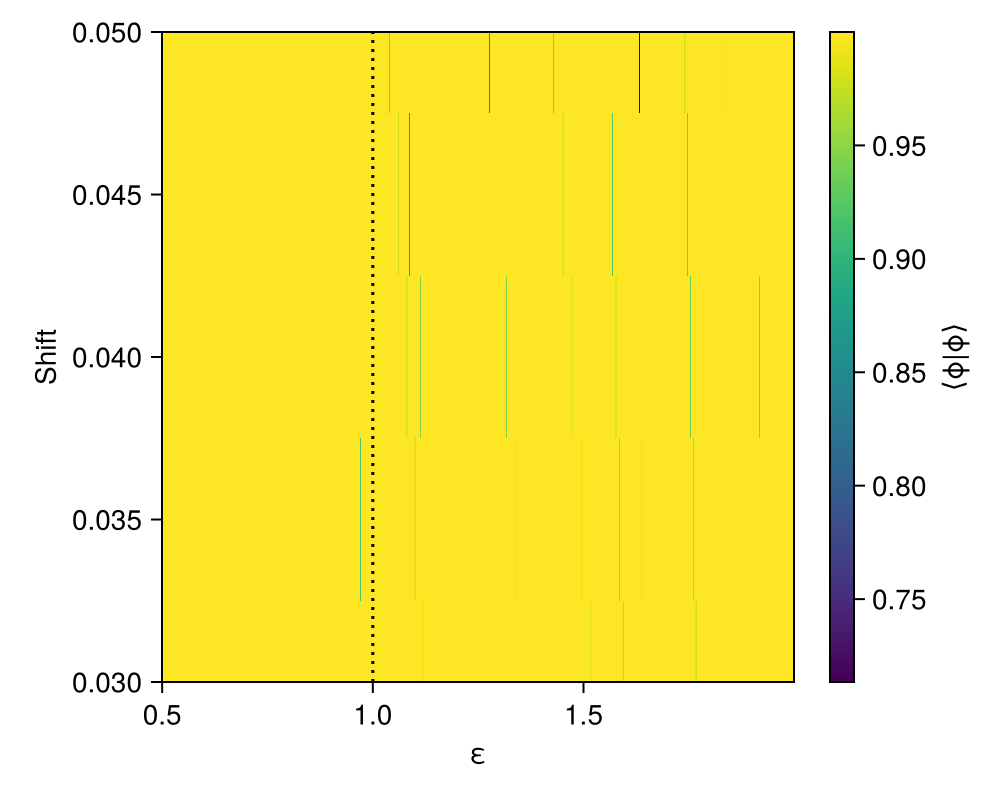

CairoMakie.Screen{IMAGE}


In [452]:
fig = cm.Figure(size = (500,400))
ax = cm.Axis(fig[1,1], xlabel = "ε", ylabel = "Shift", limits = (nothing, (minimum(stark_shifts), maximum(stark_shifts))))

to_plot = dat_for_plot_overlap
cm.heatmap!(ax, collect(eps.val[1:end-1]), collect(stark_shifts), to_plot)
cm.vlines!(1, color = "black", linestyle = :dot, label = "max for fit")

cm.Colorbar(fig[1,2], limits = [minimum(to_plot[to_plot .> -Inf]), maximum(to_plot)], label = "⟨ϕ|ϕ⟩")
#cm.Legend(fig[2,1], ax, orientation = :horizontal)


display(fig)

In [453]:
size(dat_for_plot_overlap[:,1])

(1999,)

In [454]:
loc1 = argmin(dat_for_plot_overlap[:,3])
println(loc1)
loc2 = loc1+1

sum(fmode_dat_cc[loc1,3,:].*fmode_dat[loc2,3,:])

611


0.9045753322863216 - 4.765647055827768e-9im

## Checking Floquet Mode Continuity

In [455]:
stark_shifts = (fmodes.axes[:shift]);
states = (fmodes.axes[:state]);
eps = (fmodes.axes[:eps]);

In [464]:
eps_loc = loc1
shift_loc = 3
fmode_dat_1 = collect(fmodes.layer[Re_Im = At("Re"), eps = At(eps[eps_loc]), shift = At(stark_shifts[shift_loc])].data+1im*fmodes.layer[Re_Im = At("Im"), eps = At(eps[eps_loc]), shift = At(stark_shifts[shift_loc])].data);

fmode_dat_p1_cc = collect(fmodes.layer[Re_Im = At("Re"), eps = At(eps[eps_loc+1]), shift = At(stark_shifts[shift_loc])].data-1im*fmodes.layer[Re_Im = At("Im"), eps = At(eps[eps_loc+1]), shift = At(stark_shifts[shift_loc])].data);

In [466]:
test = zeros(ComplexF64, 100,100)
@tensor test[i,j] = fmode_dat_p1_cc[i,n]*fmode_dat_1[j,n]

test = abs.(test);

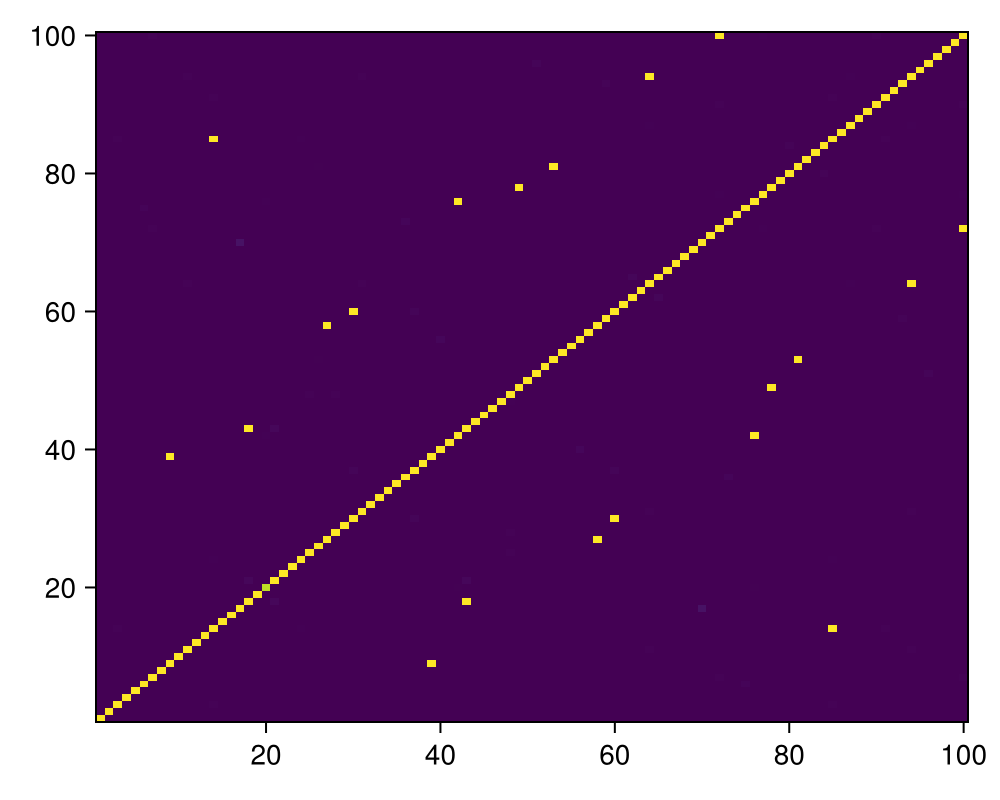

CairoMakie.Screen{IMAGE}


In [467]:
fig = cm.Figure(size = (500,400))
ax = cm.Axis(fig[1,1])

to_plot = test
cm.heatmap!(ax,1:100, 1:100, to_plot)



display(fig)

# Optimizing Pulses along the On Resonance Line

## Setup 

In [105]:
x = abs.(1.0.-dat_for_plot_f0)

ε_indices = []
for i in 1:length(x[1,:])
    push!(ε_indices, argmin(x[i,:]))
end

ss_indices = []
for i in 1:length(x[:,1])
    push!(ss_indices, argmin(x[:,i]))
end

In [25]:
findmin(abs.(eps.-1.8))[2]

173

### Overlay Plot

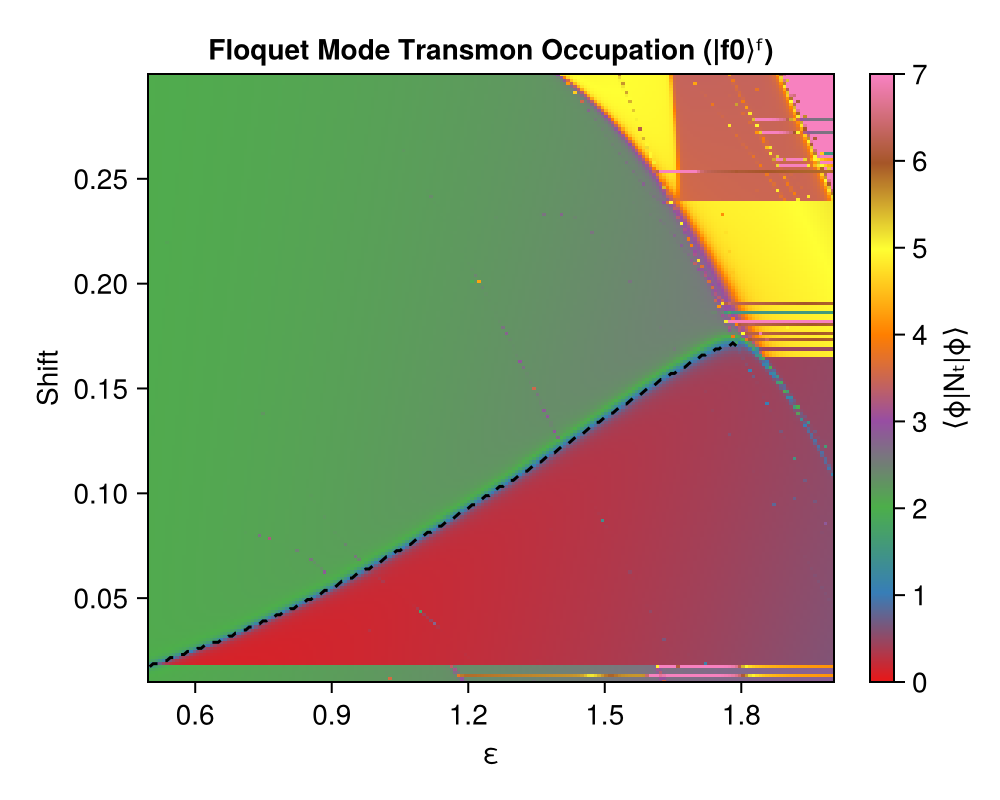

CairoMakie.Screen{IMAGE}


In [26]:
fig = cm.Figure(size = (500,400))
ax = cm.Axis(fig[1,1], xlabel = "ε", ylabel = "Shift", title = "Floquet Mode Transmon Occupation (|f0⟩ᶠ)", limits = (nothing, (minimum(stark_shifts), maximum(stark_shifts))))

joint_limits = [0,7]
cmap = :Set1_8
to_plot = dat_for_plot_f0
hm = cm.heatmap!(ax, collect(eps.val), collect(stark_shifts), to_plot, colormap = cmap, colorrange = joint_limits)

cutoff = findmin(abs.(eps.-1.8))[2]
x = collect(eps.val)[1:cutoff]
y = (collect(stark_shifts.val)[ε_indices])[1:cutoff]
cm.lines!(x,y, color = "black", linestyle = :dash)

cm.Colorbar(fig[1,2], hm, label = "⟨ϕ|Nₜ|ϕ⟩", ticks = joint_limits[1]:joint_limits[end])
#cm.Legend(fig[2,1], ax, orientation = :horizontal)

display(fig)

## Doing Fits

In [27]:
abs_difs[1, 1:2]

2-element Vector{Float64}:
 0.01653639638660387
 0.013619053611620302

In [28]:
offset = 30
eps_for_fit = collect(eps.val)[offset:cutoff]

half_width = 5
ss_for_fit = []
difs_for_fit = []

for i in offset:(offset+length(eps_for_fit))
    i0 = ε_indices[i]
    i1 = i0-half_width
    i2 = i0+half_width

    shifts = collect(stark_shifts.val)[i1:i2]
    push!(ss_for_fit, shifts)

    push!(difs_for_fit, abs_difs[i, i1:i2])
end

In [29]:
fits = []
to_fit(t, p) = p[3].*sqrt.((t.-p[1]).^2 .+ p[2].^2)

for i in 1:length(eps_for_fit)
    difs = difs_for_fit[i]
    x = ss_for_fit[i]
    p0 = zeros(3)
    p0[1] = x[argmin(difs)]
    p0[2] = minimum(difs)
    p0[3] = abs((maximum(difs)-minimum(difs))/(x[argmax(difs)]-x[argmin(difs)]))
    fit = LF.curve_fit(to_fit, x, difs, p0)
    
    push!(fits, fit)
end

#### Overlay of Fits

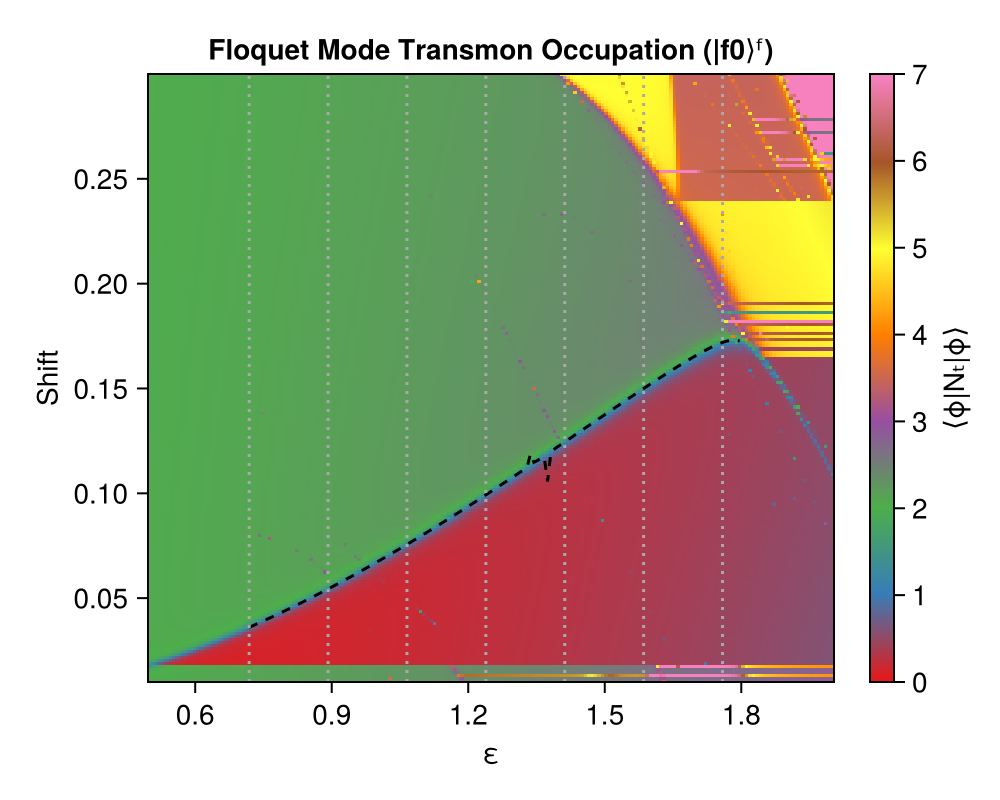

CairoMakie.Screen{IMAGE}


In [30]:
fig = cm.Figure(size = (500,400))
ax = cm.Axis(fig[1,1], xlabel = "ε", ylabel = "Shift", title = "Floquet Mode Transmon Occupation (|f0⟩ᶠ)", limits = (nothing, (minimum(stark_shifts), maximum(stark_shifts))))

joint_limits = [0,7]
cmap = :Set1_8
to_plot = dat_for_plot_f0
hm = cm.heatmap!(ax, collect(eps.val), collect(stark_shifts), to_plot, colormap = cmap, colorrange = joint_limits)

x = eps_for_fit
y = [fit.param[1] for fit in fits]
cm.lines!(x,y, color = "black", linestyle = :dash)

cm.Colorbar(fig[1,2], hm, label = "⟨ϕ|Nₜ|ϕ⟩", ticks = joint_limits[1]:joint_limits[end])

#cm.Legend(fig[2,1], ax, orientation = :horizontal)

for x in eps_for_fit[1:23:end]
    cm.vlines!(x, color = "darkgrey", linestyle = :dot)
end

display(fig)

In [31]:
every = 23

pulse_fits = []

to_sample = 1:every:length(eps_for_fit)
for ii in 1:length(to_sample)
    i= to_sample[ii]
    @info "On fit $ii out of $(length(to_sample))"
    ε = eps_for_fit[i]
    freq_d = Mode3.Stuff["op_drive_params"]["sb_f0g1"]["freq_d"]
    shift = fits[i].param[1]

    envelope = Mode3.Stuff["op_drive_params"]["sb_f0g1"]["Envelope"]
    envelope_args = deepcopy(Mode3.Stuff["op_drive_params"]["sb_f0g1"]["Envelope Args"])

    t0 = 1/(fits[i].param[2]*fits[i].param[3])

    t_range = [t0, t0+2*envelope_args["ramp_time"]]

    ψ1 = Mode3.dressed_states[(2,0)]
    ψ2 = Mode3.dressed_states[(0,1)]

    pulse = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, ε, freq_d, shift, t_range, envelope, envelope_args, levels = 5, samples_per_level = 6)
    push!(pulse_fits, pulse)
    @info "++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++"
    @info "++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++"
    
end

[2025-01-16 16:46:21] Info: On fit 1 out of 7
[2025-01-16 16:46:22] Info: On Level 1
[2025-01-16 16:46:22] Info: On Step 1: t = 197.06956555021554
[2025-01-16 16:46:22] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 07s (ETA: 0h 00m 00s)
[2025-01-16 16:46:31] Info: Time Evolution Complete
[2025-01-16 16:46:31] Info: Done with Level_1_step_1
[2025-01-16 16:46:31] Info: Accurace: 0.9904404737162276
[2025-01-16 16:46:31] Info: ------------------------------------------------------------------------------
[2025-01-16 16:46:31] Info: On Step 2: t = 201.71984555021555
[2025-01-16 16:46:31] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2025-01-16 16:46:37] Info: Time Evolution Complete
[2025-01-16 16:46:37] Info: Done with Level_1_step_2
[2025-01-16 16:46:37] Info: Accurace: 0.9962106228194348
[2025-01-16 16:46:37] Info: ------------------------------------

In [32]:
fidelities = []
for pulse in pulse_fits
    push!(fidelities, pulse["accuracy"])
end

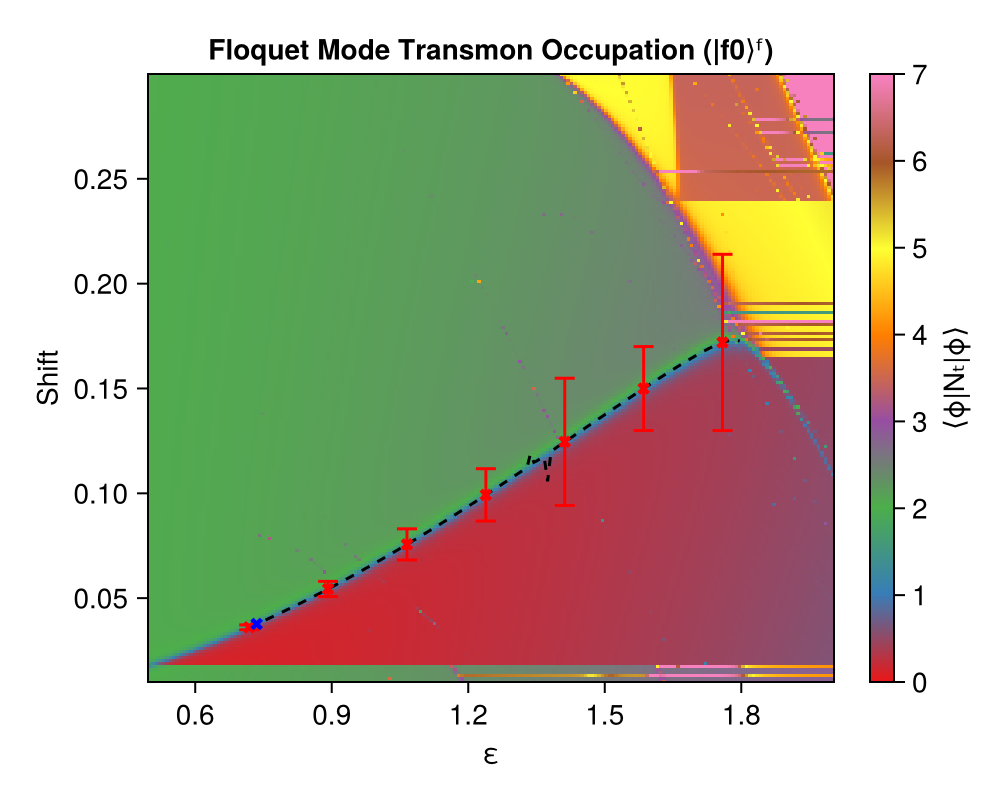

CairoMakie.Screen{IMAGE}


In [38]:
fig = cm.Figure(size = (500,400))
ax = cm.Axis(fig[1,1], xlabel = "ε", ylabel = "Shift", title = "Floquet Mode Transmon Occupation (|f0⟩ᶠ)", limits = (nothing, (minimum(stark_shifts), maximum(stark_shifts))))

joint_limits = [0,7]
cmap = :Set1_8
to_plot = dat_for_plot_f0
hm = cm.heatmap!(ax, collect(eps.val), collect(stark_shifts), to_plot, colormap = cmap, colorrange = joint_limits)

x = eps_for_fit
y = [fit.param[1] for fit in fits]
cm.lines!(x,y, color = "black", linestyle = :dash)

cm.Colorbar(fig[1,2], hm, label = "⟨ϕ|Nₜ|ϕ⟩", ticks = joint_limits[1]:joint_limits[end])

#cm.Legend(fig[2,1], ax, orientation = :horizontal)

x = eps_for_fit[to_sample]
y = [fit.param[1] for fit in fits][to_sample]
cm.scatter!(x, y, color = "red", label = "Fits", marker = :x)
cm.errorbars!(x, y, (1 .- fidelities)*10/2, color = "red", whiskerwidth = 10)

cm.scatter!(Mode3.Stuff["op_drive_params"]["sb_f0g1"]["epsilon"], Mode3.Stuff["op_drive_params"]["sb_f0g1"]["shift"], color = "blue", marker = :x)

display(fig)

In [37]:
(1 .- fidelities)*10

7-element Vector{Float64}:
 0.002352706570064589
 0.007229230900885897
 0.014872915153951727
 0.02497483649756216
 0.06065070558213814
 0.04005676668187075
 0.08409374295847094

In [40]:
open("Data/test_fits.json", "w") do io
    JSON3.pretty(io, pulse_fits)
end

In [41]:
Mode3.Stuff["op_drive_params"]["sb_f0g1"]["shift"]

0.037664663557229916

# Resolution Scaling 

In [689]:
Mode3BigT = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode3BiggerT/Mode3BiggerT.json");

In [690]:
dats = []
push!(dats, open_dataset("Data/FloqIonization_250_Mon-Jan-20-25_18_34/quasistates.nc"))
push!(dats, open_dataset("Data/FloqIonization_731_Mon-Jan-20-25_18_29/quasistates.nc"))
push!(dats, open_dataset("Data/FloqIonization_1000_Mon-Jan-20-25_18_31/quasistates.nc"))
push!(dats, open_dataset("Data/FloqIonization_2000_Mon-Jan-20-25_18_21/quasistates.nc"))
push!(dats, open_dataset("Data/FloqIonization_3000_Mon-Jan-20-25_18_19/quasistates.nc"))
push!(dats, open_dataset("Data/FloqIonization_BiggerT_1000_Tue-Jan-21-25_10_38/quasistates.nc"))

6-element Vector{Any}:
 YAXArray Dataset
Shared Axes: 
  (↓ state Categorical{String} [(7, 1), (0, 3), …, (9, 0), (6, 7)] Unordered,
  → eps   Sampled{Float64} 0.5:0.006024096385542169:2.0 ForwardOrdered Regular Points,
  ↗ shift Sampled{Float64} StepRangeLen(0.03766, 0.0, 1) ForwardOrdered Regular Points,
  ⬔ Re_Im Categorical{String} ["Re", "Im"] ReverseOrdered,
  ◩ idx   Sampled{Int64} 1:1:100 ForwardOrdered Regular Points)

Variables: 
layer


 YAXArray Dataset
Shared Axes: 
  (↓ state Categorical{String} [(7, 1), (0, 3), …, (9, 0), (6, 7)] Unordered,
  → eps   Sampled{Float64} 0.5:0.002054794520547945:2.0 ForwardOrdered Regular Points,
  ↗ shift Sampled{Float64} StepRangeLen(0.03766, 0.0, 1) ForwardOrdered Regular Points,
  ⬔ Re_Im Categorical{String} ["Re", "Im"] ReverseOrdered,
  ◩ idx   Sampled{Int64} 1:1:100 ForwardOrdered Regular Points)

Variables: 
layer


 YAXArray Dataset
Shared Axes: 
  (↓ state Categorical{String} [(7, 1), (0, 3), …, (9, 0), (6, 7)] Unordered,
  → eps  

In [698]:
tmat = zeros(10,10)
id_mat = zeros(10,10)
for i in 1:10
    tmat[i,i] = i-1
    id_mat[i,i] = 1
end

tmat = kron(tmat, id_mat);

state = (2,0)

ys = []
for i in 1:(length(dats)-1)
    ϕs = collect(dats[i].layer[Re_Im = At("Re"), state = At(string(state))].data)+1im*collect(dats[i].layer[Re_Im = At("Im"), state = At(string(state))].data)
ϕs_cc = collect(dats[i].layer[Re_Im = At("Re"), state = At(string(state))].data)-1im*collect(dats[i].layer[Re_Im = At("Im"), state = At(string(state))].data)
    push!(ys, abs.(sum([ϕs_cc[:,:,m].*tmat[m,n].*ϕs[:,:,n] for n in 1:100 for m in 1:100]))[:])
end

tmat = zeros(20,20)
for i in 1:20
    tmat[i,i] = i-1
end

tmat = kron(tmat, id_mat);
for i in length(dats)
    ϕs = collect(dats[i].layer[Re_Im = At("Re"), state = At(string(state))].data)+1im*collect(dats[i].layer[Re_Im = At("Im"), state = At(string(state))].data)
    ϕs_cc = collect(dats[i].layer[Re_Im = At("Re"), state = At(string(state))].data)-1im*collect(dats[i].layer[Re_Im = At("Im"), state = At(string(state))].data)
    push!(ys, abs.(sum([ϕs_cc[:,:,m].*tmat[m,n].*ϕs[:,:,n] for n in 1:100 for m in 1:100]))[:])
end

In [699]:
collect(dats[1].axes[:shift].val)

1-element Vector{Float64}:
 0.03766

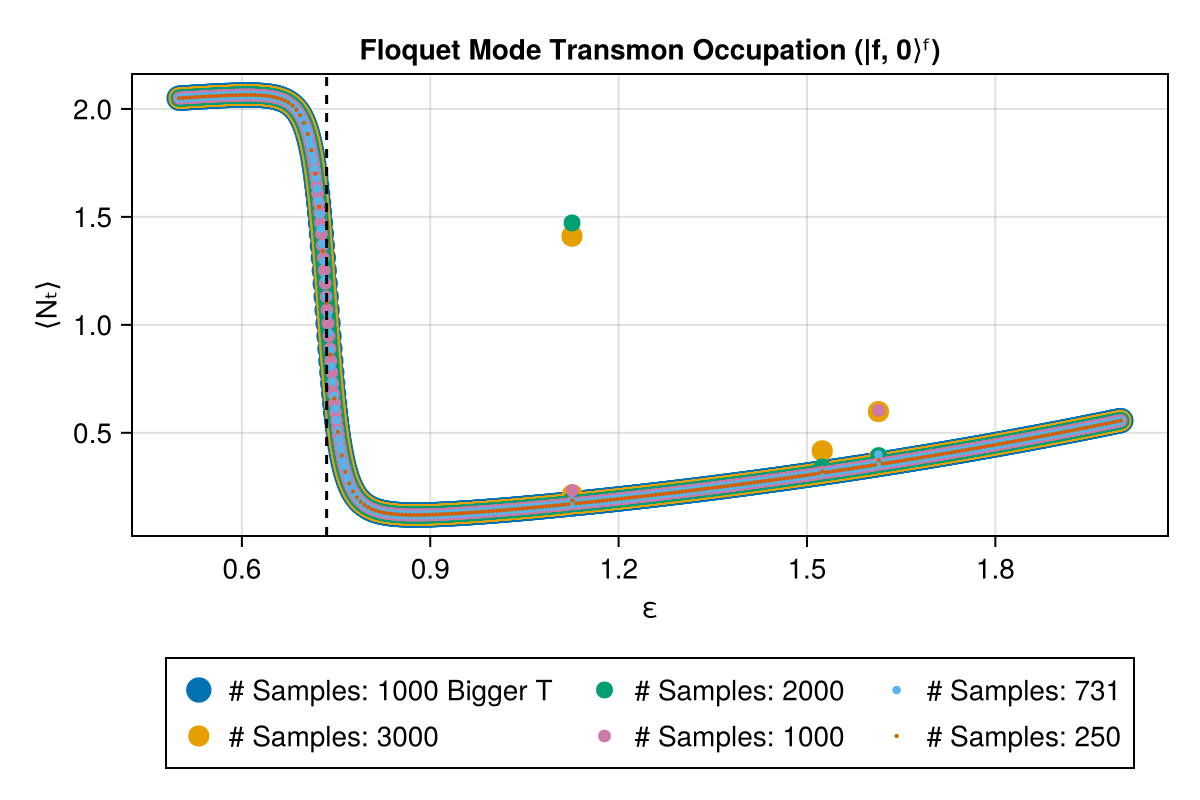

In [700]:
fig = cm.Figure(size = (600,400), px_per_unit = 0.1)
tlevels = ["g", "e", "f", "h", "i", "j", "k", "l", "m", "n"]
ax = cm.Axis(fig[1,1], xlabel = "ε", ylabel = "⟨Nₜ⟩", title = "Floquet Mode Transmon Occupation (|$(tlevels[state[1]+1]), $(state[2])⟩ᶠ)")



for i in (length(dats).-collect(1:length(dats)).+1)
    x = collect(dats[i].axes[:eps].val)
    label = "# Samples: $(length(ys[i]))"
    if i == length(dats)
        label = "# Samples: $(length(ys[i])) Bigger T"
    end
    cm.scatter!(ax, x, ys[i], label = label, markersize = 3*i)
end

cm.vlines!(ax, Mode3.Stuff["op_drive_params"]["sb_f0g1"]["epsilon"], color = "black", linestyle = :dash)

cm.Legend(fig[2,1], ax, orientation = :horizontal, nbanks = 2)

fig